In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

import irbasis3
from numpy.polynomial.legendre import leggauss
from itertools import product

import sys
sys.path.insert(0, "../src/")

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax import grad, jit

In [4]:
from spmomega.solver import SpMSolver
from spmomega.quad import composite_leggauss, scale_quad

In [136]:
wmax = 5.0
beta = 10.0
lambda_ = wmax * beta
K = irbasis3.KernelFFlat(lambda_)
basis = irbasis3.FiniteTempBasis(K, "F", beta, eps=1e-15)

In [137]:
solver = SpMSolver(basis)
print(solver.smpl_points)

[-5.         -4.98250823 -4.96501646 -4.89211604 -4.81921561 -4.6948668
 -4.57051799 -4.40483116 -4.23914432 -4.04398441 -3.84882449 -3.63593357
 -3.42304265 -3.20272711 -2.98241158 -2.76290382 -2.54339606 -2.33077906
 -2.11816205 -1.91665013 -1.71513821 -1.5275258  -1.33991339 -1.16808264
 -0.99625189 -0.84175583 -0.68725976 -0.55214049 -0.41702122 -0.30379263
 -0.19056404 -0.09528202  0.          0.09528202  0.19056404  0.30379263
  0.41702122  0.55214049  0.68725976  0.84175583  0.99625189  1.16808264
  1.33991339  1.5275258   1.71513821  1.91665013  2.11816205  2.33077906
  2.54339606  2.76290382  2.98241158  3.20272711  3.42304265  3.63593357
  3.84882449  4.04398441  4.23914432  4.40483116  4.57051799  4.6948668
  4.81921561  4.89211604  4.96501646  4.98250823  5.        ]


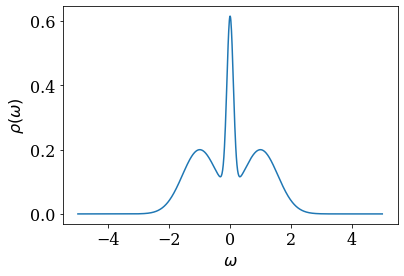

In [138]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

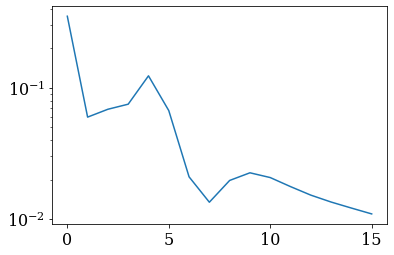

In [139]:
# Expand the spectral function in IR
x, w = composite_leggauss(solver.smpl_points, 10)
all_l = np.arange(basis.s.size)

rhol = np.einsum('lw,w,w->l', basis.v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)
gl = - basis.s * rhol

plt.semilogy(np.abs(rhol)[::2])

In [239]:
from spmomega.solver import _oversample
rho_l0 = 1e-2*np.random.randn(solver._basis.size)
tau = _oversample(irbasis3.TauSampling(basis).sampling_points, 2)
gtau = basis.u(tau).T @ gl
rho_l_reconst = solver.fit_gtau(tau, gtau, reg_L1=1e-10, rho_l0=rhol, tol=1e-15, gtol=1e-15, penalty=0.1)
rho_l_reconst

      fun: -21.94781944271396
 hess_inv: array([[ 1.08506643e-11, -5.06963245e-13, -1.31723211e-11, ...,
         1.01663528e-09, -1.06830718e-11, -1.69385143e-10],
       [-5.06963243e-13,  1.39439109e-11,  3.96917940e-12, ...,
         2.11300199e-10,  8.37701894e-11, -2.53258558e-10],
       [-1.31723211e-11,  3.96917940e-12,  7.08465171e-11, ...,
         4.03855025e-10, -7.98822965e-10, -1.96215676e-10],
       ...,
       [ 1.01663528e-09,  2.11300199e-10,  4.03855031e-10, ...,
         5.11114577e-06, -2.38692936e-07, -1.36923561e-06],
       [-1.06830721e-11,  8.37701894e-11, -7.98822966e-10, ...,
        -2.38692937e-07,  2.08752850e-07,  5.07779789e-08],
       [-1.69385143e-10, -2.53258558e-10, -1.96215678e-10, ...,
        -1.36923561e-06,  5.07779786e-08,  4.32393828e-07]])
      jac: array([-5.74860363e+04,  1.41271151e+04, -3.51374590e+04,  8.35637566e+03,
       -4.62537018e+03,  2.67602113e+03, -1.53721298e+03,  8.70917894e+02,
       -2.80453308e+02,  4.94872169e+02, 

array([ 3.51891026e-01, -8.21027427e-08, -5.98950697e-02, -1.33621803e-07,
       -6.87456505e-02, -1.26240808e-06, -7.51560915e-02, -1.80799969e-05,
        1.23515366e-01,  1.02791992e-04, -6.67054197e-02,  3.70656199e-03,
        3.10007807e-02, -1.41053589e-02, -5.15789713e-02,  2.31959405e-02,
        8.79297555e-02, -2.23746056e-02, -9.91165752e-02,  1.27680289e-02,
        7.96219088e-02, -3.76979807e-04, -4.70989869e-02, -9.38954048e-03,
        1.85864496e-02,  1.28192104e-02, -2.32842421e-03, -9.52182242e-03,
       -2.51831755e-03,  4.08159885e-03,  1.46283139e-03, -7.85397447e-04])

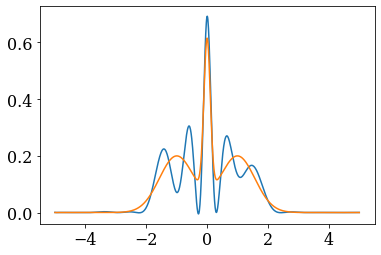

In [240]:
omegas = np.linspace(-wmax, wmax , 1000)

rho_omega_reconst = basis.v(omegas).T @ rho_l_reconst
plt.plot(omegas, rho_omega_reconst, marker="")
plt.plot(omegas, rho(omegas), marker="")

In [ ]:
rho_l0 = np.zeros(solver._basis.size)
#b_smpl0 = np.sqrt(rho(solver.smpl_points))[:,None,None]
#b_smpl0 = b_smpl0 + 1j*np.random.randn(solver.smpl_points.size,1,1) * 1e-5
rho_l_reconst = solver.fit_g_l(gl, reg_L1=1e-7, rho_l0=rhol, tol=1e-10, gtol=1e-10, penalty=0.01)
rho_l_reconst

In [96]:
x, w = composite_leggauss(solver.smpl_points, 10)
print(np.sum(rho(x) * w))
print(np.sum((basis.v(x).T @ rho_l_reconst) * w))

0.7071067811865476
0.7071045659014747


In [218]:
np.maximum(np.array([0.1, 0.0, -0.1]), 0)

array([0.1, 0. , 0. ])

In [79]:
from spmomega import _xp

#f = lambda x: _xp.sum(_xp.abs(x) - x)
f = lambda x: _xp.sum(_xp.abs(x) - x)

fp = grad(f)

x = np.array([-0.1])
print(f(x))
print(fp(x))

0.2
[-2.]


In [85]:
for x in np.linspace(-1, 1, 10):
    print(x, f(np.array([x])), fp(np.array([x])))

-1.0 2.0 [-2.]
-0.7777777777777778 1.5555555555555556 [-2.]
-0.5555555555555556 1.1111111111111112 [-2.]
-0.33333333333333337 0.6666666666666667 [-2.]
-0.11111111111111116 0.22222222222222232 [-2.]
0.11111111111111116 0.0 [0.]
0.33333333333333326 0.0 [0.]
0.5555555555555554 0.0 [0.]
0.7777777777777777 0.0 [0.]
1.0 0.0 [0.]


      fun: 2.6957623751503232e-11
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00, -4.00368514e-51, ...,
         0.00000000e+00,  6.57518972e-51,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.00368514e-51,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00, -4.00368490e-51,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.57518972e-51,  0.00000000e+00, -4.00368490e-51, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
      jac: array([ 2.02881057e-38, -0.00000000e+00, -4.15980676e-38, -0.00000000e+00,
        3.61463368e-38, -0.00000000e+00,  4.19712713e-39, -0.00000000e+00,
        2.92512758e-38, -0.00000000e+

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


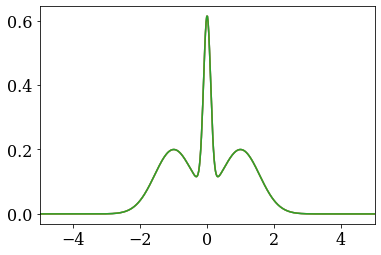

In [250]:
b_smpl_reconst1 = solver.fit_g_l(gl[:,None,None], 1e-14, b_smpl0=b_smpl)
omegas = np.linspace(-10, 10 , 1000)
plt.xlim([-5, 5])
plt.plot(omegas, solver.interpolate(b_smpl, omegas)[:,0,0], marker="")
plt.plot(omegas, solver.interpolate(b_smpl_reconst1, omegas)[:,0,0], marker="")
plt.plot(omegas, rho(omegas), marker="")

ValueError: x and y must have same first dimension, but have shapes (500,) and (41,)

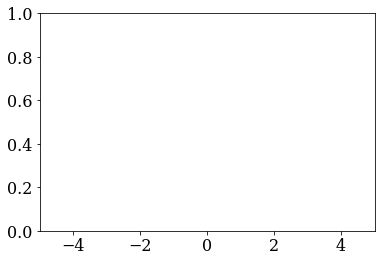

In [251]:
plt.xlim([-5,5])
plt.plot(solver.smpl_points, b_smpl_reconst[:,0,0] * np.conj(b_smpl_reconst[:,0,0]), marker="o")
plt.plot(omegas, solver.interpolate(b_smpl_reconst, omegas)[:,0,0], marker="")

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


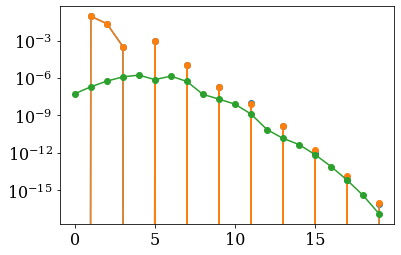

In [ ]:
plt.semilogy(solver.g_l(b_smpl_reconst)[::2,0,0], marker="o")
plt.semilogy(gl[::2], marker="o")
plt.semilogy(np.abs(gl[::2]- solver.g_l(b_smpl_reconst)[::2,0,0]), marker="o")


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


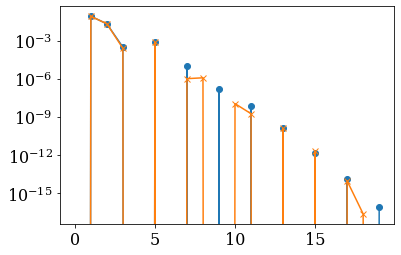

In [ ]:
x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, -wmax, wmax)
gl2 = -basis.s * np.einsum('w,w,lw->l', solver.interpolate(b_smpl_reconst, x)[:,0,0], w, basis.v(x))

plt.semilogy(gl[::2], marker="o")
plt.semilogy(gl2[::2], marker="x")

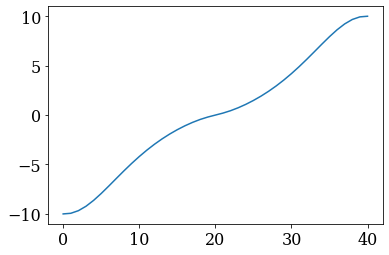

In [ ]:
plt.plot(solver.smpl_points)